In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.dates import DayLocator, DateFormatter
import matplotlib.dates as mdates

# import matplotlib.dates as mdates
dateFmt = DateFormatter('%b')

VOLUME_FILE = "res/surface_velocities/volumes_processed.parquet"
TEMPERATURE_FILE = "res/surface_velocities/temperature_processed.parquet"
SURF_VEL_FILE = "res/surface_velocities/TS_punto-fronte.txt"
SURF_VEL_FILE = "res/surface_velocities/TS_punto-corpo.txt"

icepy_dir = Path.cwd().parents[1]

# Read dataframes
vol_df = pd.read_parquet(icepy_dir / VOLUME_FILE)
temp_df = pd.read_parquet(icepy_dir / TEMPERATURE_FILE)
surfvel_df = pd.read_csv(icepy_dir / SURF_VEL_FILE)


#### Volume vs temperature


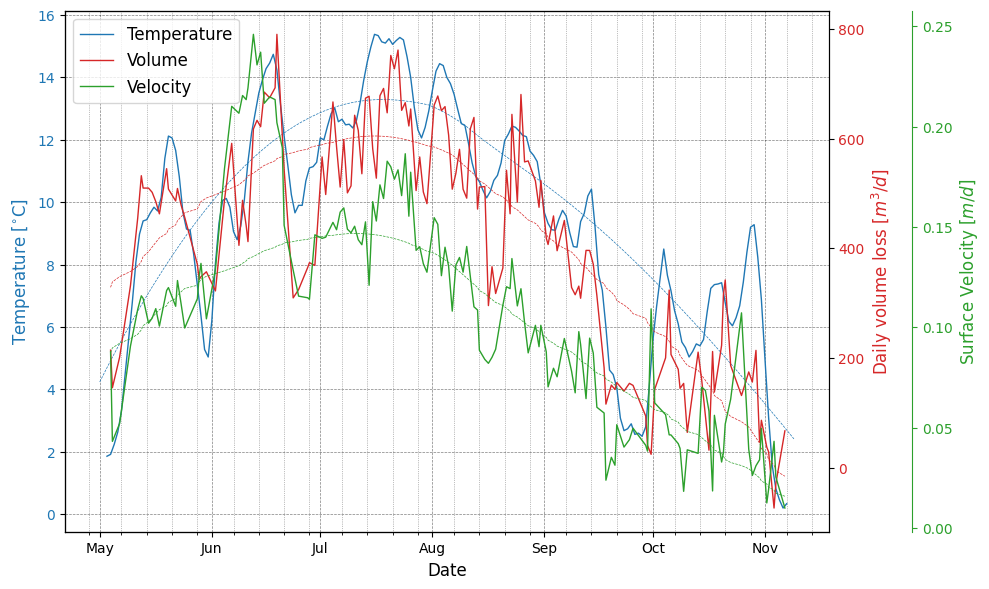

In [2]:
# Create host and parasite subplots
fig, host = plt.subplots(figsize=(10, 6))
par1 = host.twinx()
par2 = host.twinx()

# Plot temperature in host subplot
p1, = host.plot(temp_df["day_plot"], temp_df["Tavg_5d"], label="Temperature", linewidth=1, linestyle = 'solid', color="tab:blue")
p4 = host.plot(temp_df["day_plot"], temp_df["Tavg_5d_rloess"], label="Temperature trend", linewidth=0.5, linestyle = 'dashed', color="tab:blue")
 
# Plot volume loss
p2, = par1.plot(vol_df["day_plot"], -vol_df["volume_daily_normalized"], label="Volume", linewidth=1, linestyle = 'solid', color="tab:red")
p5 =  par1.plot(vol_df["day_plot"], -vol_df["volume_daily_norm_rloess"], label="Volume trend", linewidth=0.5, linestyle = 'dashed', color="tab:red")

# Plot surface velocity
p3, = par2.plot(vol_df["day_plot"], surfvel_df["V"], label="Velocity", linewidth=1, linestyle = 'solid',color="tab:green")
p6 = par2.plot(vol_df["day_plot"], surfvel_df["Vsmooth"], label="velocity trend", linewidth=0.5, linestyle = 'dashed',color="tab:green")


# Set x and y labels
host.set_xlabel("Date", fontsize=12)
host.set_ylabel("Temperature [$^{\circ}$C]", fontsize=12, color="tab:blue")
par1.set_ylabel("Daily volume loss [$m^3/d$]", fontsize=12, color="tab:red")
par2.set_ylabel("Surface velocity [$m/d$]", fontsize=12, color="tab:green")

# Set x and y labels
host.set_xlabel("Date", fontsize=12)
host.set_ylabel("Temperature [$^{\circ}$C]", fontsize=12, color="tab:blue")
par1.set_ylabel("Daily volume loss [$m^3/d$]", fontsize=12, color="tab:red")
par2.set_ylabel("Surface Velocity [$m/d$]", fontsize=12, color="tab:green")

# Set x-axis date format
dateFmt = DateFormatter('%b')
host.xaxis.set_major_formatter(dateFmt)

# Set grid lines
host.grid(which="both", linestyle="--", alpha=0.5)
host.grid(which="major", axis="y", linewidth=0.5, color="black")
host.grid(which="major", axis="x", linewidth=0.5, color="black")
host.xaxis.set_minor_locator(DayLocator(bymonthday=[7, 14, 21, 28], interval=1, tz=None))
host.grid(which="minor", axis="y", linestyle=":", linewidth=0.5, color="black")
host.grid(which="minor", axis="x", linestyle=":", linewidth=0.5, color="black")

# Adjust the positioning and scale of the third y-axis
par2.spines["right"].set_position(("outward", 60))
par2.spines["right"].set_color("tab:green")
par2.yaxis.label.set_color("tab:green")
par2.tick_params(axis="y", colors="tab:green")
par2.spines["right"].set_visible(True)
par2.yaxis.label.set_visible(True)

# Update the legend to include the surface velocity plot
lines = [p1, p2, p3]
labels = [line.get_label() for line in lines]
host.legend(lines, labels, loc="upper left", fontsize=12)

# Set colors
host.tick_params(axis="y", labelcolor="tab:blue")
par1.tick_params(axis="y", labelcolor="tab:red")
host.yaxis.label.set_color("tab:blue")
par1.yaxis.label.set_color("tab:red")
par2.yaxis.label.set_color("tab:green")

# Set title
# plt.title(f"Temperature, Volume Loss, and Surface Velocity (step {TSTEP} days)", fontsize=14)
plt.tight_layout()
# fig.savefig(df_out_dir / f"{Path(SURF_VEL_FILE).stem}.png", dpi=300)

In [3]:
# Export pandas dataframes to csv
df_out_dir = "res/surface_velocities"
df_out_dir = icepy_dir = Path.cwd().parents[1] / df_out_dir

vol_df.to_csv(df_out_dir / f"volumes_processed.csv", index=False)
temp_df.to_csv(df_out_dir / f"temperature_processed.csv", index=False)
surfvel_df.to_csv(df_out_dir / f"surface_velocities_processed.csv", index=False)

In [4]:
x = vol_df["volume_daily_normalized"] - vol_df["volume_daily_norm_rloess"]
y = surfvel_df["V"] - surfvel_df["Vsmooth"] 

In [ ]:
# Cross correlation
import statsmodels.tsa.stattools as smt

# y = temp["Tavg_5d"] - temp["Tavg_5d_rloess"]
# smt.ccf(x, y, adjusted=True, fft=True)

from scipy.signal import correlate
from scipy.signal import correlation_lags

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to calculate correlation
def correlation(x, y):
    shortest = min(x.shape[0], y.shape[0])
    return np.corrcoef(x.iloc[:shortest].values, y.iloc[:shortest].values)[0, 1]

# Function to plot time series and show the correlation
def plot_correlation(x, y, text):
    # plot 
    plt.subplots(figsize=(10, 6))
    x.plot(label="x")
    y.plot(label="y")
    plt.title(f"Correlation {text}: {correlation(x, y)}")
    plt.legend(loc="best")
    plt.show()

# Show results without shifting
plot_correlation(x, y, "before shifting")

# Function to calculate cross-correlation,
# extract the best matching shift and then shift
# one of the series appropriately.
def shift_for_maximum_correlation(x, y):
    correlation = correlate(x, y, mode="full")
    lags = correlation_lags(x.size, y.size, mode="full")
    lag = lags[np.argmax(correlation)]
    print(f"Best lag: {lag}")
    if lag < 0:
        y = y.iloc[abs(lag):].reset_index(drop=True)
    else:
        x = x.iloc[lag:].reset_index(drop=True)
    return x, y

# Plot results after shifting
shifted_x, shifted_y = shift_for_maximum_correlation(x, y)
plot_correlation(shifted_x, shifted_y, text="after shifting")

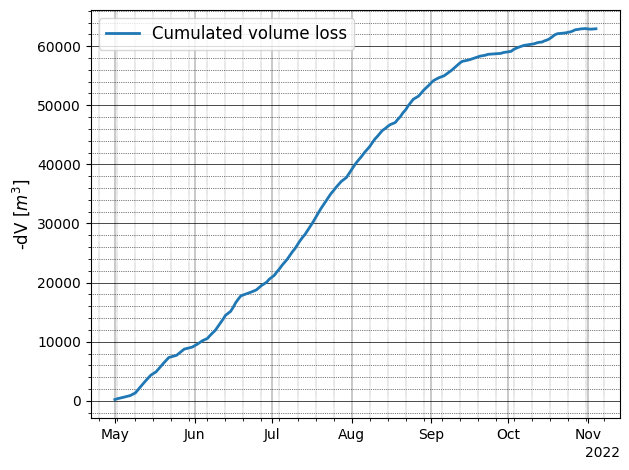

In [5]:
# Make plot for Cumulated volumes
TSTEP = 5
major_locator = mdates.MonthLocator(interval=1)
major_formatter = mdates.ConciseDateFormatter(major_locator)
minor_locator =  mdates.WeekdayLocator(byweekday=0, interval=1)

fig, ax = plt.subplots()
fig.set_tight_layout(True)
p1 = ax.plot(vol_df["date_in"], -vol_df["volume_daily_norm_cumul"], label="Cumulated volume loss", linewidth=2, color="tab:blue")
ax.set_ylabel("-dV [$m^3$]", fontsize=12)
ax.grid(True)
ax.minorticks_on()
ax.grid(which="major", axis="y", linewidth=0.5, color="black")
ax.grid(which="major", axis="x", linewidth=0.3, color="black")
ax.grid(which="minor", axis="y", linestyle=":", linewidth=0.5, color="black")
ax.grid(which="minor", axis="x", linestyle=":", linewidth=0.3, color="black")
ax.xaxis.set_major_locator(major_locator)
ax.xaxis.set_major_formatter(major_formatter)
ax.xaxis.set_minor_locator(minor_locator)

# Set legend
lines = p1
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc="upper left", fontsize=12)
plt.tight_layout()

icepy_dir = Path.cwd().parents[1]
fig.savefig( icepy_dir / f"res/fig_for_paper/delta_volumi_stereo_cumlated.png", dpi=300)

plt.show()



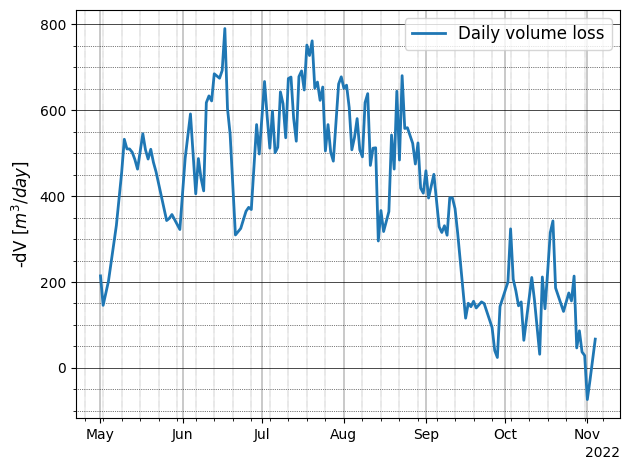

In [6]:
# Make plot for daily volumes loss
fig, ax = plt.subplots()
fig.set_tight_layout(True)
p1 = ax.plot(vol_df["date_in"], -vol_df["volume_daily_normalized"], label="Daily volume loss", linewidth=2, color="tab:blue")
ax.set_ylabel("-dV [$m^3/day$]", fontsize=12)
ax.grid(True)
ax.minorticks_on()
ax.grid(which="major", axis="y", linewidth=0.5, color="black")
ax.grid(which="major", axis="x", linewidth=0.3, color="black")
ax.grid(which="minor", axis="y", linestyle=":", linewidth=0.5, color="black")
ax.grid(which="minor", axis="x", linestyle=":", linewidth=0.3, color="black")
ax.xaxis.set_major_locator(major_locator)
ax.xaxis.set_major_formatter(major_formatter)
ax.xaxis.set_minor_locator(minor_locator)

# Set legend
lines = p1
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc="upper right", fontsize=12)
plt.tight_layout()

icepy_dir = Path.cwd().parents[1]
fig.savefig( icepy_dir / f"res/fig_for_paper/delta_volumi_stereo_daily.png", dpi=300)
plt.show()



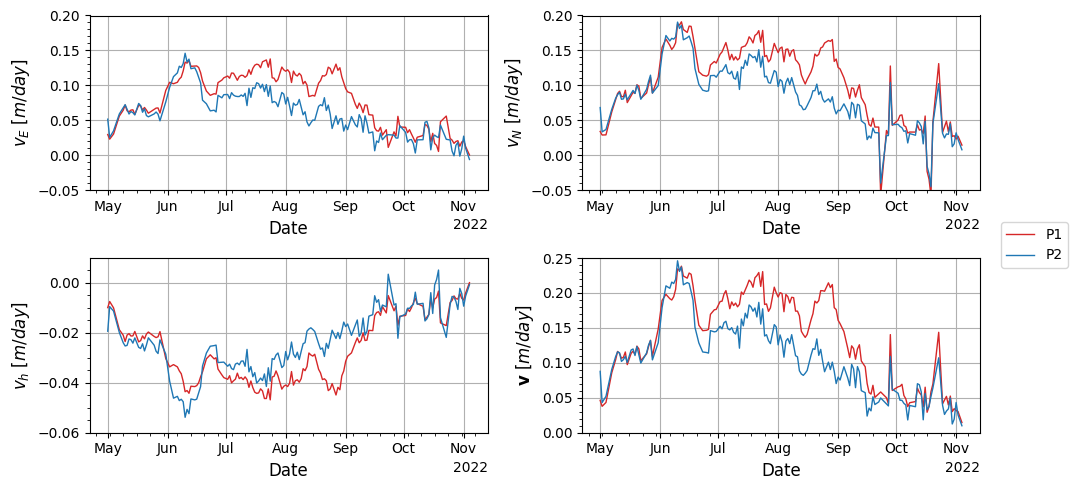

In [7]:
# Plot surface velocities components
SURF_VEL_P1_FILE = "res/surface_velocities/TS_punto-fronte.txt"
SURF_VEL_P2_FILE = "res/surface_velocities/TS_punto-corpo.txt"

icepy_dir = Path.cwd().parents[1]

# Read dataframes
vol_df = pd.read_parquet(icepy_dir / VOLUME_FILE)
temp_df = pd.read_parquet(icepy_dir / TEMPERATURE_FILE)
p1_vel = pd.read_csv(icepy_dir / SURF_VEL_P1_FILE)
p2_vel = pd.read_csv(icepy_dir / SURF_VEL_P2_FILE)
p1_vel["t1"] = pd.to_datetime(p1_vel["t1"], format="%d-%b-%Y") 
p1_vel["t2"] = pd.to_datetime(p1_vel["t2"], format="%d-%b-%Y") 
p2_vel["t1"] = pd.to_datetime(p2_vel["t1"], format="%d-%b-%Y") 
p2_vel["t2"] = pd.to_datetime(p2_vel["t2"], format="%d-%b-%Y") 

# Define locators for grid and ticks
major_locator = mdates.MonthLocator(interval=1)
major_formatter = mdates.ConciseDateFormatter(major_locator)
minor_locator =  mdates.WeekdayLocator(byweekday=0, interval=1)

def set_ax_propr(ax, show_xlabel= True, ylabel = None, ylim=None, show_legend=False):
    if show_xlabel: 
        ax.set_xlabel("Date", fontsize=12)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=12)
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.grid(True)
    dateFmt = DateFormatter('%b')
    ax.xaxis.set_major_formatter(dateFmt)
    ax.xaxis.set_major_locator(DayLocator(interval=30))    
    ax.minorticks_on()
    # ax.grid(which="major", axis="y", linewidth=0.5, color="black")
    # ax.grid(which="major", axis="x", linewidth=0.3, color="black")
    # ax.grid(which="minor", axis="y", linestyle=":", linewidth=0.5, color="black")
    # ax.grid(which="minor", axis="x", linestyle=":", linewidth=0.3, color="black")
    ax.xaxis.set_major_locator(major_locator)
    ax.xaxis.set_major_formatter(major_formatter)
    ax.xaxis.set_minor_locator(minor_locator)
    if show_legend:
        ax.legend(fontsize=12)


fig, axes = plt.subplots(2,2, figsize=(10,5))
axes[0,0].plot(p1_vel["t1"], p1_vel["dx"], label="P1", linewidth=1, color="tab:red")
axes[0,0].plot(p2_vel["t1"], p2_vel["dx"], label="P2", linewidth=1, color="tab:blue")
set_ax_propr(axes[0,0], ylabel="$\mathit{v}_E$ [$m/day$]", ylim=(-0.05, 0.20))
axes[0,1].plot(p1_vel["t1"], p1_vel["dy"], label="P1", linewidth=1, color="tab:red")
axes[0,1].plot(p2_vel["t1"], p2_vel["dy"], label="P2", linewidth=1, color="tab:blue")
set_ax_propr(axes[0,1], ylabel="$\mathit{v}_N$ [$m/day$]", ylim=(-0.05, 0.20))
axes[1,0].plot(p1_vel["t1"], p1_vel["dz"], label="P1", linewidth=1, color="tab:red")
axes[1,0].plot(p2_vel["t1"], p2_vel["dz"], label="P2", linewidth=1, color="tab:blue")
set_ax_propr(axes[1,0], ylabel="$\mathit{v}_h$ [$m/day$]", ylim=(-0.06, 0.01))
axes[1,1].plot(p1_vel["t1"], p1_vel["V"], label="P1", linewidth=1, color="tab:red")
axes[1,1].plot(p2_vel["t1"], p2_vel["V"], label="P2", linewidth=1, color="tab:blue")
set_ax_propr(axes[1,1], ylabel="$\mathbf{v}$ [$m/day$]", ylim=(0.0, 0.25))

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.08, 0.5))
fig.set_tight_layout(True)


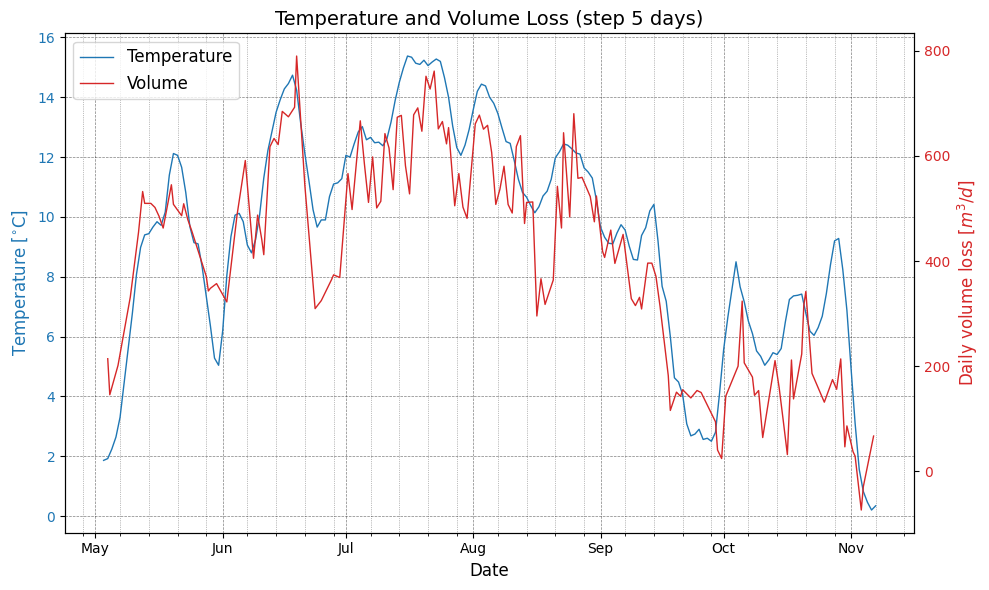

In [8]:
# Plot only volume-temperatures

# Create host and parasite subplots
fig, host = plt.subplots(figsize=(10, 6))
par = host.twinx()

# Create temperature and volume plots
p1, = host.plot(temp_df["day_plot"], temp_df["Tavg_5d"], label="Temperature", linewidth=1, color="tab:blue")
p2, = par.plot(vol_df["day_plot"], -vol_df["volume_daily_normalized"], label="Volume", linewidth=1, color="tab:red")

# Set x and y labels
host.set_xlabel("Date", fontsize=12)
host.set_ylabel("Temperature [$^{\circ}$C]", fontsize=12, color="tab:blue")
par.set_ylabel("Daily volume loss [$m^3/d$]", fontsize=12, color="tab:red")

# Set x-axis date format
dateFmt = DateFormatter('%b')
host.xaxis.set_major_formatter(dateFmt)

# Set grid lines
host.grid(which="both", linestyle="--", alpha=0.5)
host.grid(which="major", axis="y", linewidth=0.5, color="black")
host.grid(which="major", axis="x", linewidth=0.5, color="black")
host.xaxis.set_minor_locator(DayLocator(bymonthday=[7, 14, 21, 28], interval=1, tz=None))
host.grid(which="minor", axis="y", linestyle=":", linewidth=0.5, color="black")
host.grid(which="minor", axis="x", linestyle=":", linewidth=0.5, color="black")

# Set legend
lines = [p1, p2]
labels = [line.get_label() for line in lines]
host.legend(lines, labels, loc="upper left", fontsize=12)

# Set colors
host.tick_params(axis="y", labelcolor="tab:blue")
par.tick_params(axis="y", labelcolor="tab:red")
host.yaxis.label.set_color("tab:blue")
par.yaxis.label.set_color("tab:red")

# Set title
plt.title(f"Temperature and Volume Loss (step {TSTEP} days)", fontsize=14)
plt.tight_layout()

plt.show()


In [ ]:
# OLD Test for rolling average
# volumes["day_plot"] = volumes["date_in"] + np.timedelta64(5, "D") 
# volumes["day_plot"] = volumes["date_in"]
# temp["day_plot"] = temp["data"]
# temp["Tmed_5d"] = temp["Tmed"] .rolling(5, min_periods=1, center=False).mean()


# Trying to manaully compute rolling average on the same time window as the volume (differs from a regular rolling average with fixed time window is almost negligible)

# merged = pd.merge(temp, volumes, left_on="data", right_on="date_in", how="left")
# merged = merged[["data", "Tmed", "date_in", "date_fin"]]

# merged['rol_avg'] = np.nan
# for i in range(len(merged["date_in"])):
#     if pd.isna(merged["date_in"][i]):
#         continue    
#     d_in = merged["date_in"][i]
#     d_fin = merged["date_fin"][i]
#     mask = (merged['data'] >= d_in) & (merged['data'] < d_fin)
#     avg = merged['Tmed'][mask].mean()
#     merged['rol_avg'][i]  = avg
 
# T_roll_avg = merged[["date_in", "date_fin", "rol_avg"]][merged["date_in"].notnull()]